In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def imshow(line, col, title, image):
    ax[line, col].imshow(image)
    ax[line, col].set_title(title)
    
def plot(line, col, title, xAxis, yAxis):
    ax[line, col].plot(xAxis, yAxis)
    ax[line, col].set_title(title)

# Détourage d'une image de boite

the principle is as follows :
1. use color to isolate blue color2. this results in a mask with unregular contour
2. find the irregular contour for the mask and make it regular. This results in a new mask
3. using the new mask, extract the blue box from the picture
4. determine the corners of the ROI (blue box)
5. create an alpha channel to make the background transparent
6. extract only the blue box and save as PNG. It must have background transparent



- Lecture image : imread
- conversion en HSV cv2.cvtColor(img, cv2.COLOR_BGR2HSV )
- selection d'un mask sur couleur bleu grâce à cv2.inRange(imgHSV, lower, upper)  
- sélection de l'image sur la base du mask : cv2.bitwise_and(img,img,mask=mask)

- recherche de contour, prendre le plus grand cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
- use cv2.convexHull(contours[areaMaxIdx]) to make the contour regular


- récupérer les corners
    -  peri = cv2.arcLength(cnt, True)
    - corners = cv2.approxPolyDP(cnt, 0.002 * peri, True)
    - x, y, w, h = cv2.boundingRect(corners)

- sur l'(image détourée, on plitte les channels
- on créé un channel alpha en utilisant le mask
- on merge tous les channels

- on extrait l'image de la boite en utilisant les corners
- on sauvegarde l'image en PNG

(1512, 2016, 3)
shape mask =  (1512, 2016)
2
(1, 2, 4)
[[[ 1 -1 -1 -1]
  [-1  0 -1 -1]]]
0  area :  0.0
1  area :  598355.5
max contour =  1
(1512, 2016)
result_alpha.shape =  (1512, 2016, 4)
shape mask3 =  (1512, 2016)


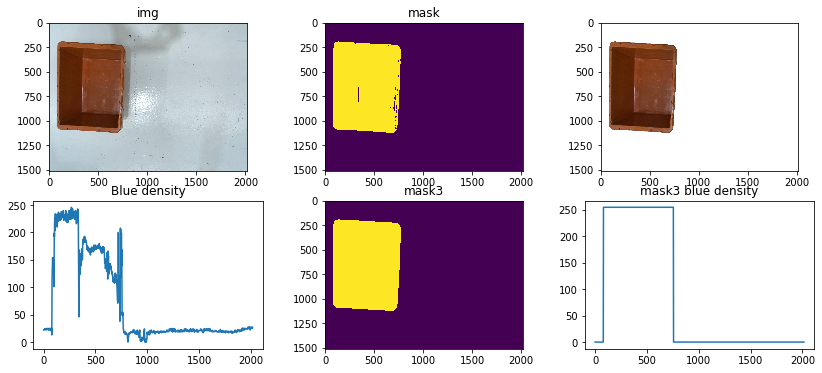

-1

In [127]:
fig, ax = plt.subplots(2,3,figsize=(14, 6))

img = cv2.imread('Photos Rack EDM 20201027\\IMG_3126.JPG')
img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
(yMax, xMax,c) = img.shape
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV )


# result = np.zeros(img.shape) 
temp = img.copy()
mask =  np.zeros(img.shape) #mask out of HSV selection. there may be gaps in the selection (eroded contour, ...)
mask2 =  np.zeros(img.shape) #refined mask
mask3 =  np.zeros(img.shape) #refined mask

print(img.shape)


imshow(0,0,"img", img)
plot(1,0,"Blue density", range(0,xMax),imgHSV[yMax//2,:,1] )
# ax[1,0].plot(range(0,xMax),imgHSV[yMax//2,:,1])


# 1. creation of the first mask : we detect the box using blue color. The result is "mask"
# the mask may  be irregular
lower = np.array([0, 100, 0])
upper = np.array([179,255,255])
mask = cv2.inRange(imgHSV, lower, upper)
print("shape mask = ", mask.shape)
#                 OUT : mask

# 2. Detection of the contours for that mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print (len(contours))
print(hierarchy.shape)
print(hierarchy)

# Selection of the biggest contour
areaMax = 0
areaMaxIdx = 0
areaIdx = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(areaIdx, ' area : ', area)
    if area > areaMax:
        areaMax = area
        areaMaxIdx = areaIdx
    areaIdx+=1
print("max contour = ", areaMaxIdx)

# this is the magic : the selected contour may not be regular => we use convexHull to make sure that we have a regular contour
contours[areaMaxIdx] = cv2.convexHull(contours[areaMaxIdx])
# OUT : contours[areaMaxIdx] which contains the regular outline of the blue box

# 3. Let's create new mask (mask3) based on the this selected contour
cv2.drawContours(mask2, contours, areaMaxIdx,(255,255,255), -1)   # -1 = fill the contour
lower = np.array([100, 100, 100])
upper = np.array([255,255,255])
mask3 = cv2.inRange(mask2, lower, upper)    # use of "inRange" to ake sure that mask3 has the right mask format. otherwise I got issues
print(mask3.shape)
# OUT : mask3


# 4. detramine corners of ROI
peri = cv2.arcLength(contours[areaMaxIdx], True)
corners = cv2.approxPolyDP(contours[areaMaxIdx], 0.002 * peri, True)    # small threshold to make sure that the bounding bow really takes everything
objCorner = len(corners)
x, y, w, h = cv2.boundingRect(corners)
# cv2.rectangle(result, (x, y), (x + w, y + h), (255,255, 0), 1)
# OUT : location of the ROI

# 5. Create Alpha channel
b_channel, g_channel, r_channel = cv2.split(img)
alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * mask3
result_alpha = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
print("result_alpha.shape = ",result_alpha.shape)
# OUT : result_alpha which is the image with everything transparent but the blue box

# 6. Extract ROI and save as PNG
box = result_alpha[y:y+h,x:x+w]
cv2.imwrite("box.png", box)
cv2.imwrite("result.png", result_alpha)


# mask3, g_channel, r_channel = cv2.split(mask2)
imshow(0,1,"mask", mask)
imshow(1,1,"mask3", mask3)
ax[0,2].imshow(result_alpha)
plot(1,2,"mask3 blue density",range(0,xMax),mask3[yMax//2,:])
print("shape mask3 = ", mask3.shape)
# result = cv2.bitwise_and(img,img,mask=mask3)



# result = cv2.bitwise_and(img,img,mask=mask2)





plt.show()

cv2.imshow("result", mask2)
cv2.waitKey(0)